# Deploying Agents with Amazon Bedrock AgentCore

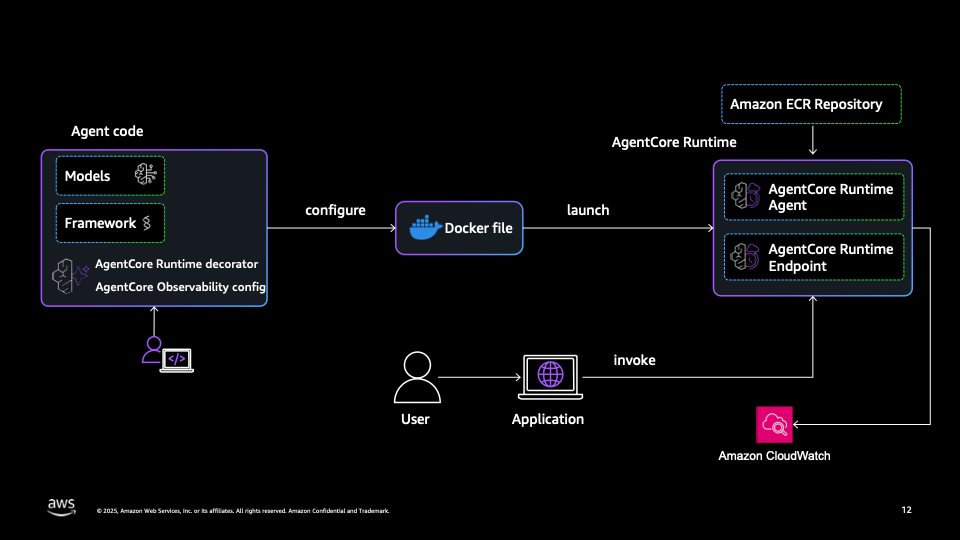

In the previous notebook ```strands-agents.ipynb```, we learned how to create Agent Code using Strands 
Agents. The next step is to deploy the agent to your enterprise environment.

Amazon Bedrock AgentCore provides fully managed, production-ready hosting for your agentic 
applications.

## What is Amazon Bedrock AgentCore?

Amazon Bedrock AgentCore is a managed service that handles the operational complexity of running AI 
agents in production environments. It provides production-ready deployment by providing followings:

• **Scalable Infrastructure** - Automatically scales based on demand<br/>
• **Security & Compliance** - Enterprise-grade security controls<br/>
• **Monitoring & Observability** - Built-in logging and metrics<br/>
• **High Availability** - Multi-AZ deployment with failover capabilities<br/>

## Deployment Process

This notebook shows how the `bedrock-agentcore-starter-toolkit` simplifies the entire deployment process for AgentCore Runtime.

1. **Prepare agent code in local environment**
2. **Configure deployment using a toolkit**
3. **Build & Deploy to AgentCore Runtime**
4. **Invoke AgentCore Runtime Endpoint**
5. **Monitoring using CloudWatch GenerativeAI Observability**



### Prerequisites

<div class="alert alert-block alert-info">
	⚠️ <b>Important:</b> ⚠️</br> Make sure you've executed <code>strands-agents.ipynb</code> before proceeding.
</div>

#### 1. Enable CloudWatch GenAI Observability

From AWS Console, navigate to **Cloud Watch** service, and follow the steps below:<br/>
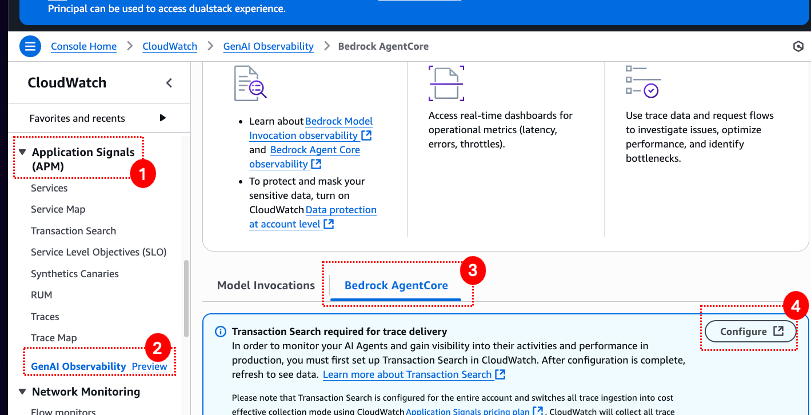
<br/>
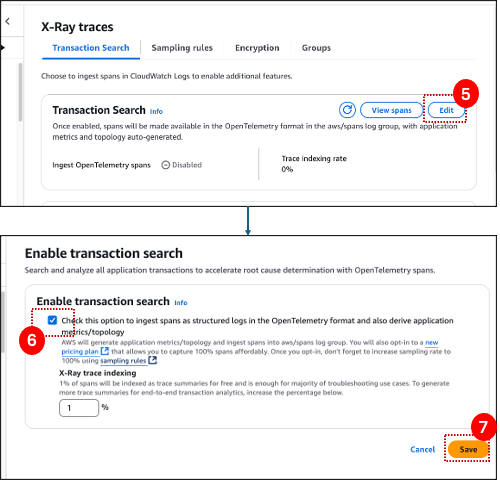
<br/>

**It will take 5-10 minutes to enable the feature. Please proceed to the next steps while waiting for completion.**

# Let us get Started!
## Productionize the Agents with Amazon Bedrock Agentcore

### 1: Preparing development environment

#### Import Required Packages and Configure Environment

In [ ]:
import os
import json
import time
import requests
from datetime import datetime
from pathlib import Path

# Strands imports
from strands.models.bedrock import BedrockModel
from strands import Agent, tool
from strands_tools import retrieve, http_request
from strands.tools.mcp.mcp_client import MCPClient
from mcp.client.stdio import stdio_client, StdioServerParameters

# AgentCore imports
from bedrock_agentcore.runtime import BedrockAgentCoreApp
from bedrock_agentcore_starter_toolkit import Runtime

from boto3.session import Session
boto_session = Session()
region = boto_session.region_name

# Configure environment
os.environ["BYPASS_TOOL_CONSENT"] = "true"

# Configure model
model = BedrockModel(model_id="us.anthropic.claude-3-5-sonnet-20241022-v2:0")

print("All imports loaded successfully")
print(region)

# Load the knowledge base ID
with open('kb_id.txt', 'r') as f:
    kb_id = f.read().strip()
    
print(f"Knowledge Base ID: {kb_id}")

#### Create IAM Role for Deployed Agents

In [2]:
import boto3
import json

def create_agentcore_role(kb_id):
    iam = boto3.client('iam')
    account_id = boto3.client("sts").get_caller_identity()["Account"]
    
    trust_policy = {
        "Version": "2012-10-17",
        "Statement": [{
            "Effect": "Allow",
            "Principal": {"Service": "bedrock-agentcore.amazonaws.com"},
            "Action": "sts:AssumeRole"
        }]
    }
    
    policy = {
        "Version": "2012-10-17",
        "Statement": [
            {"Effect": "Allow", "Action": ["bedrock:InvokeModel", "bedrock:InvokeModelWithResponseStream"], "Resource": "arn:aws:bedrock:*::foundation-model/*"},
            {"Effect": "Allow", "Action": ["bedrock:InvokeModel", "bedrock:InvokeModelWithResponseStream"], "Resource": f"arn:aws:bedrock:*:{account_id}:inference-profile/*"},
            {"Effect": "Allow", "Action": ["bedrock:Retrieve", "bedrock:RetrieveAndGenerate"], "Resource": f"arn:aws:bedrock:{region}:{account_id}:knowledge-base/*"},
            {"Effect": "Allow", "Action": ["ecr:BatchGetImage", "ecr:GetDownloadUrlForLayer"], "Resource": f"arn:aws:ecr:{region}:{account_id}:repository/*"},
            {"Effect": "Allow", "Action": ["ecr:GetAuthorizationToken"], "Resource": "*"},
            {"Effect": "Allow", "Action": ["logs:CreateLogGroup", "logs:CreateLogStream", "logs:PutLogEvents"], "Resource": f"arn:aws:logs:{region}:{account_id}:log-group:/aws/bedrock-agentcore/runtimes/*"},
            {"Effect": "Allow", "Action": ["cloudwatch:PutMetricData"], "Resource": "*"},
            {"Effect": "Allow", "Action": ["xray:PutTraceSegments", "xray:PutTelemetryRecords"], "Resource": "*"},
            {"Effect": "Allow", "Action": ["bedrock-agentcore:GetWorkloadAccessToken", "bedrock-agentcore:GetWorkloadAccessTokenForJWT", "bedrock-agentcore:GetWorkloadAccessTokenForUserId"], 
             "Resource": [f"arn:aws:bedrock-agentcore:{region}:{account_id}:workload-identity-directory/default", 
                          f"arn:aws:bedrock-agentcore:{region}:{account_id}:workload-identity-directory/default/workload-identity/*"]}
        ]
    }
    
    try:
        iam.create_role(RoleName="AgentCoreRuntimeRole", AssumeRolePolicyDocument=json.dumps(trust_policy))
        iam.put_role_policy(RoleName="AgentCoreRuntimeRole", PolicyName="Policy", PolicyDocument=json.dumps(policy))
    except: pass
    
    return f"arn:aws:iam::{account_id}:role/AgentCoreRuntimeRole"

agentcore_role_arn = create_agentcore_role(kb_id)

#### Create a Helper Function to orchestrate AgentCore deployment steps

In [ ]:
# AMAZON BEDROCK AGENTCORE: Official Production Agent Deployment
# Amazon Bedrock AgentCore Runtime is a secure, serverless runtime designed for 
# deploying and scaling AI agents and tools, supporting any frameworks, models, 
# and protocolsx

from bedrock_agentcore_starter_toolkit import Runtime
import json
import time

def deploy_agent_to_agentcore(agent_file, agent_name):
    """Deploy agent using Python SDK (more reliable for notebooks)
    
    AMAZON BEDROCK AGENTCORE RUNTIME ARCHITECTURE:
    - Secure, serverless runtime capability for deploying and scaling AI agents and tools
    - Supports any framework (Strands, LangGraph, CrewAI), protocol, or model choice  
    - Enables rapid prototyping, seamless scaling, and accelerated time to market
    - Provides zero infrastructure management with production-ready hosting
    - Transforms local prototypes into production solutions with minimal code changes
    (Source: amazon-bedrock-agentcore-samples/README.md, bedrock-agentcore-starter-toolkit/README.md)
    
    AGENTCORE SDK INTEGRATION:
    - Lightweight wrapper that deploys agent functions as HTTP services compatible with Amazon Bedrock
    - Handles all HTTP server details so developers can focus on agent core functionality
    - Uses @app.entrypoint decorator pattern for function deployment
    - Invokable via AWS developer tools: boto3, AWS SDK for JavaScript, AWS SDK for Java
    (Source: amazon-bedrock-agentcore-samples/01-tutorials/01-AgentCore-runtime/README.md)
    """
    print(f"Deploying {agent_name} using Python SDK...")
    
    try:
        # AGENTCORE RUNTIME INITIALIZATION:
        # The Runtime class from bedrock_agentcore_starter_toolkit manages the complete
        # deployment lifecycle for Amazon Bedrock AgentCore Runtime
        runtime = Runtime()
        
        # AGENTCORE PLATFORM CAPABILITIES:
        # Amazon Bedrock AgentCore provides composable services that work together:
        # - Runtime: Serverless deployment and scaling with framework flexibility
        # - Memory: Persistent knowledge with event and semantic memory capabilities  
        # - Gateway: Transform APIs and Lambda functions into MCP-compatible tools
        # - Identity: Secure authentication and access management integration
        # - Tools: Built-in Code Interpreter and Browser tools for enhanced capabilities
        # - Observability: Real-time monitoring and tracing with OpenTelemetry support
        
        # AGENT DEPLOYMENT CONFIGURATION:
        print("Configuring agent...")
        runtime.configure(
            entrypoint=agent_file,  # Python file containing agent implementation
            agent_name=agent_name,  # Unique identifier for the deployed agent
            execution_role=agentcore_role_arn,  # IAM role for agent execution permissions
            auto_create_ecr=True,  # Automatic container registry management
            requirements_file="requirements.txt"  # Python dependencies specification
            
            # ADDITIONAL CONFIGURATION OPTIONS:
            # The AgentCore Runtime supports various configuration options for
            # production deployment, though specific parameters depend on your
            # agent requirements and organizational policies
        )
        print("Configuration successful!")
        
        # AGENTCORE DEPLOYMENT LAUNCH:
        # The launch process deploys your agent to Amazon Bedrock AgentCore Runtime
        # with serverless scaling and production-ready hosting capabilities
        print("Launching with CodeBuild...")
        runtime.launch(auto_update_on_conflict=True)
        
        # LAUNCH PROCESS CAPABILITIES:
        # - Containerized deployment with Docker/Finch integration
        # - Automatic scaling based on demand with serverless architecture
        # - Integration with Amazon Bedrock platform for model access
        # - HTTP service creation for agent invocation via AWS SDKs
        # - Production-ready hosting with enterprise-grade reliability
        
        print("Launch successful!")
        
        # POST-DEPLOYMENT AGENT ACCESS:
        # Once deployed, agents can be invoked through:
        # - Amazon Bedrock AgentCore SDK (Python)
        # - AWS boto3 (Python AWS SDK)
        # - AWS SDK for JavaScript 
        # - AWS SDK for Java
        # - Other AWS developer tools
        
        return runtime
        
    except Exception as e:
        # ERROR HANDLING FOR AGENTCORE DEPLOYMENT:
        print(f"Deployment failed: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        
        import traceback
        print("Full traceback:")
        traceback.print_exc()
        
        return None

print("Python SDK deployment function ready!")

### 2. Web Scraper Agent (Use Case 1) 

#### Prepare Agent Code

We are resuing the same agent code from the use case. <br/>
Note additional code added with a few lines to define entrypoint for the agent invocation. Check out the code prepared in `web_research_agent.py`

In [4]:
# AMAZON BEDROCK AGENTCORE: Agent File Creation and Deployment Pattern
# This demonstrates the complete workflow from local development to AgentCore Runtime deployment
# using the BedrockAgentCoreApp SDK integration pattern.

# AGENTCORE SDK INTEGRATION PATTERN:
# The BedrockAgentCoreApp provides a lightweight wrapper that transforms agent functions 
# into HTTP services compatible with Amazon Bedrock, handling all server details so 
# developers can focus on agent core functionality.

agent_code = '''from bedrock_agentcore import BedrockAgentCoreApp
from strands import Agent
from strands.models import BedrockModel
from strands_tools import http_request

# BEDROCK AGENTCORE APP INITIALIZATION:
# BedrockAgentCoreApp is the primary SDK class for deploying agents to AgentCore Runtime.
# It provides the framework-agnostic foundation for any agent implementation.
app = BedrockAgentCoreApp()

# STRANDS AGENTS FRAMEWORK INTEGRATION:
# Amazon Bedrock AgentCore supports any agentic framework including Strands Agents.
# This demonstrates framework flexibility - you can use Strands, LangGraph, CrewAI,
# or any other framework with AgentCore Runtime.

# Create the web research agent with scraping capabilities
agent = Agent(

    model=BedrockModel(model_id="us.anthropic.claude-3-5-sonnet-20241022-v2:0"),
    tools=[http_request],
    system_prompt="""
    You are a web research specialist. Your capabilities include:
    
    1. Web Scraping: Use requests and BeautifulSoup to scrape web content
    2. Data Extraction: Extract titles, links, text content, and structured data
    3. Content Analysis: Analyze and summarize web content
    
    Always use proper web scraping practices and extract meaningful, structured information.
    """
)

# AGENTCORE ENTRYPOINT DECORATOR PATTERN:
# The @app.entrypoint decorator is the key integration point for AgentCore deployment.
# This transforms your agent function into an HTTP service compatible with Amazon Bedrock.
@app.entrypoint
def agent_entrypoint(payload):
    """
    Invoke the agent with the payload
    
    AGENTCORE PAYLOAD HANDLING:
    - AgentCore Runtime passes requests as payload dictionaries
    - Standard pattern extracts user input from payload["prompt"] 
    - Return values are automatically formatted for HTTP responses
    """
    user_input = payload.get("prompt")
    print("User input:", user_input)
    response = agent(user_input)
    return response.message['content'][0]['text']

# AGENTCORE LOCAL DEVELOPMENT SUPPORT:
# The app.run() method enables local testing before AgentCore deployment.
# This supports the rapid prototyping to production workflow.
if __name__ == "__main__":
    app.run()'''

# AGENT FILE CREATION FOR AGENTCORE DEPLOYMENT:
# AgentCore Runtime requires agent code to be in a standalone Python file.
# This pattern creates the deployable agent file with all necessary imports and logic.
with open('web_research_agent.py', 'w') as f:
    f.write(agent_code)

#### Configure-Build-Deploy using the helper function
The helper function will accept the Agent code prepared, and deploy it to AgentCore Runtime.

In [ ]:
print("web_research_agent.py created successfully!")

# AGENTCORE RUNTIME DEPLOYMENT WORKFLOW:
# This demonstrates the complete deployment process from local development to 
# production-ready hosting on Amazon Bedrock AgentCore Runtime.

# Deploy using Runtime class (CodeBuild should bypass Docker)
web_runtime = deploy_agent_to_agentcore(
    agent_file="web_research_agent.py",  # Standalone Python file with @app.entrypoint
    agent_name="web_research_agent"      # Unique identifier for AgentCore service
)


#### Test Deployed Web Agent

In [ ]:
invoke_response = web_runtime.invoke({"prompt": f"""
Scrape the Hacker News front page (https://news.ycombinator.com/) and extract:
1. The top 10 article titles
2. Their corresponding URLs
3. Points/score if available
4. Number of comments if available

Provide a brief summary of the main topics being discussed.
"""})
invoke_response

### 3. Repeat the same steps for Knowledge Base Agent (Use Case 11)
#### Prepare Agent code

In [ ]:
# Create Knowledge Base Agent following the official amazon-bedrock-agentcore-samples pattern
print("Creating Knowledge Base agent with correct AgentCore pattern...")

kb_agent_code = f'''import os
os.environ["BYPASS_TOOL_CONSENT"] = "true"
os.environ["KNOWLEDGE_BASE_ID"] = "{kb_id}"
os.environ["DEFAULT_KNOWLEDGE_BASE_ID"] = "{kb_id}"
os.environ["AWS_REGION"] = "{region}"

from strands import Agent
from strands_tools import retrieve
from strands.models import BedrockModel

agent = Agent(
    model=BedrockModel(model_id="us.anthropic.claude-3-5-sonnet-20241022-v2:0"),
    tools=[retrieve],
    system_prompt="""You are connected to knowledge base {kb_id} in {region}. 
    Search the knowledge base for information to answer users questions.
    Be specific about what you find."""
)

from bedrock_agentcore.runtime import BedrockAgentCoreApp
app = BedrockAgentCoreApp()

@app.entrypoint
def agent_invocation(payload, context):
    """Handler for agent invocation"""
    user_message = payload.get("prompt", "Hello! How can I help you search the knowledge base?")
    result = agent(user_message)
    print("context:\\n-------\\n", context)
    print("result:\\n*******\\n", result)
    return {{"result": result.message}}

if __name__ == "__main__":
    app.run()'''

# Write the KB agent file
with open('kb_agent.py', 'w') as f:
    f.write(kb_agent_code)

print("kb_agent.py created successfully using official AgentCore samples pattern!")
print(f"Knowledge Base ID configured: {kb_id}")

#### Configure-Build-Deploy

In [ ]:
# Deploy the Knowledge Base agent
print("Deploying Knowledge Base agent to AgentCore...")
kb_runtime = deploy_agent_to_agentcore(
    agent_file="kb_agent.py",
    agent_name="kb_agent"
)

#### Test Deployed Knowledge Base Agent

In [ ]:
invoke_response = kb_runtime.invoke({"prompt": f"""
What is AgentCore?
"""})
invoke_response

### 4. Create an Orchestrator Agent to leverage deployed Agents

#### Prepare agent code

In [ ]:
%cat researcher_agent.py

#### Configure-Build-Deploy

In [ ]:
from bedrock_agentcore_starter_toolkit import Runtime


runtime=Runtime()

runtime.configure(
    entrypoint="researcher_agent.py",  # Python file containing agent implementation
    agent_name="researcher_agent",  # Unique identifier for the deployed agent
    execution_role=agentcore_role_arn,  # IAM role for agent execution permissions
    auto_create_ecr=True,  # Automatic container registry management
    requirements_file="requirements.txt"  # Python dependencies specification

    # ADDITIONAL CONFIGURATION OPTIONS:
    # The AgentCore Runtime supports various configuration options for
    # production deployment, though specific parameters depend on your
    # agent requirements and organizational policies
)

research_agent = runtime.launch(auto_update_on_conflict=True,
                                env_vars={
                                    "AWS_REGION": region,
                                    "KB_AGENT_ARN": "arn:aws:bedrock-agentcore:us-west-2:533267405543:runtime/kb_agent-MECpMd3Q4Y",
                                    "WEB_AGENT_ARN": "arn:aws:bedrock-agentcore:us-west-2:533267405543:runtime/web_research_agent-37guWK79sg"
                                })

#### Test Orchestrator Agent

In [ ]:
runtime.invoke({"prompt": f"""
'What is AgentCore and how does it compare to current AI agent platforms?'
"""})

# Observability

### Monitoring Agent Performance
Once the Agent is deployed and tested, you can monitor how the Agent thinks, processes input, invokes tools, and generates responses using AWS CloudWatch observability features.

To access these metrics:

1. Navigate to the AWS Console
2. Go to CloudWatch
3. Select Application Signals (APM)
4. Choose GenAI Observability
5. Click on Bedrock AgentCore
   
This will provide you with detailed insights into your agent's performance and behavior patterns.